# Healthcare Accessibility Optimization

## DATA CLEANING & PREPROCESSING

### SECTION 1: Setup & Data Loading
- 1.1 Import libraries
- 1.2 Load datasets
  - 1.2.1 Ghana Health Facility Locations
  - 1.2.2 Population
  - 1.2.3 Malaria Incidence  
  - 1.2.4 Ghana Administrative Boundaries

### SECTION 2: Data Inspection & Validation
- 2.1 Check data shapes and types
- 2.2 Identify missing values
- 2.3 Examine coordinate systems
- 2.4 Validate spatial data integrity

### SECTION 3: Data Cleaning & Preprocessing
- 3.1 Handle missing values
- 3.2 Standardise coordinate systems
- 3.3 Clean facility categories
- 3.4 Population data processing

### SECTION 3A: Data Cleaning & Preprocessing (hospital and boundary data)
- 3.1 Regional boundary harmonization
- 3.2 Coordinate Duplication
- 3.3 Hospital and boundary data visualization

### SECTION 3B: Data Cleaning & Preprocessing (pop and malaria raster data)
- 3.1 Handle missing values
- 3.2 Standardise coordinate systems
- 3.3 Scale resolution to 1km

## SECTION 1: Setup & Data Loading

### __1.1 Import libraries__

In [1]:
#__1.2 Import libraries__

# Core data manipulation and analysis
import pandas as pd                       # For data manipulation and analysis
import numpy as np                        # For numerical computations

# Geospatial data handling
import geopandas as gpd                   # For handling geographic data and shapefiles
from geopandas.tools import sjoin         # For joining the grids to the boundary data
import rasterio                           # For reading and processing raster data (population, malaria)
from rasterio.features import rasterize
from rasterio.features import shapes
from rasterio.warp import calculate_default_transform, reproject, Resampling # For reprojecting rasters to target CRS
from rasterio.enums import Resampling     # For scaling the raster data pop and malaria data
import rasterio.mask                      # For define analysis region and clip rasters


# Visualization
import matplotlib.pyplot as plt           # For creating maps and visualisations
import seaborn as sns                     # For statistical visualisations
import colorcet as cc                     # for plotting the network with weights
from rasterio.plot import plotting_extent # plotting raster data
from matplotlib.colors import LogNorm     # For applying a logarithmic scale to color intensity in plots


# Spatial operations
from shapely.geometry import shape
from shapely.geometry import Polygon
from scipy.spatial.distance import cdist  # For spatial indexing and nearest neighbour searches
from scipy.spatial import cKDTree
from shapely.geometry import Point
from sklearn.cluster import KMeans        # For candidate location generation

# Network anaylsis
#import networkx as nx                     # For road network analysis and shortest path calculations
#import osmnx as ox                        # For downloading and processing OpenStreetMap road data

# others
#import os
print("library Loading complete")
print("-"*50)

library Loading complete
--------------------------------------------------


### __1.2 Load datasets__

#### __1.2.1 Ghana Health Facility Locations__

**Data Source:** Ghana Health Service facility registry, scraped from ArcGIS Ghana hospital locations database. This represents the most comprehensive public and up-to-date inventory of health facilities in Ghana.

In [2]:
# Load hospital locations from CSV file
hospitals = pd.read_csv('DATA/hospital_data_new/ghana_health_facilities_cleaned.csv')
print(f"✓ Loaded {len(hospitals)} hospitals from local CSV") # number of health facilities in data set

# Quick preview of the data structure
hospitals.head(5)    # Preview facility data structure and columns


✓ Loaded 2843 hospitals from local CSV


,OBJECTID,Region,District,FacilityNa,Type,Town,Ownership,latitude,longitude
0,1,Ashanti,Offinso North,A.M.E Zion Clinic,Clinic,Afrancho,CHAG,7.40801,-1.96317
1,2,Ashanti,Bekwai Municipal,Abenkyiman Clinic,Clinic,Anwiankwanta,Private,6.46312,-1.58592
2,3,Ashanti,Adansi North,Aboabo Health Centre,Health Centre,Aboabo No 2,Government,6.22393,-1.34982
3,4,Ashanti,Afigya-Kwabre,Aboabogya Health Centre,Health Centre,Aboabogya,Government,6.84177,-1.61098
4,5,Ashanti,Kwabre,Aboaso Health Centre,Health Centre,Aboaso,Government,6.84177,-1.61098


#### __1.2.2 Population__

**Data Source:** WorldPop Project - globally consistent population distribution estimates using satellite imagery and census data disaggregation. This is generated and not the actual but is very close to the actual. I will use 2020 since it is the most recent census conducted

In [3]:
# Open population raster file (WorldPop data)
pop_raster = rasterio.open('DATA/ghana_population_constrained/gha_ppp_2020.tif')

# Check raster properties
print(f"Population raster shape: {pop_raster.shape}")
print(f"Coordinate system: {pop_raster.crs}")
print(f"Pixel resolution: {pop_raster.res}")

# Read the actual data to get min/max values
pop_data = pop_raster.read(1)  # Extract population density values as numpy array
print(f"Population range: {pop_data.min():.1f} to {pop_data.max():.1f}")  # Show min/max population density per pixel


Population raster shape: (7721, 5337)
Coordinate system: EPSG:4326
Pixel resolution: (0.000833333329960652, 0.0008333333300090661)
Population range: -99999.0 to 240.7


#### __1.2.3 Malaria Incidence__
**Data Source:** Malaria Atlas Project (MAP) - the good standard for malaria epidemiological data, providing globally consistent malaria incidence estimates. The year will be 2019, it is also the most recently available

In [4]:
# Open malaria incidence raster (MAP data)
malaria_raster = rasterio.open('DATA/ghana_malaria_incidence/2020_Global_Pf_Incidence_GHA_2019.tiff')

# Read malaria incidence rates (cases per 1000 population)
malaria_data = malaria_raster.read(1) #  Extract malaria incidence rates as numpy array

print(f"Malaria raster shape: {malaria_data.shape}")
print(f"Incidence range: {malaria_data.min():.1f} to {malaria_data.max():.1f} per 1000") # Display incidence rate range (cases per 1000 people)
print(f"Coordinate system: {malaria_raster.crs}")

Malaria raster shape: (155, 107)
Incidence range: -9999.0 to 0.4 per 1000
Coordinate system: EPSG:4326


#### __1.4.4 Ghana Administrative Boundaries __
**Data Source:** GADM. I will load both the regional and district level boundary datasets. I will keep it seperate for now.

In [5]:
# Load Ghana regional administrative boundaries
regions = gpd.read_file('DATA/boundaries_data/gadm41_GHA_1.shp') # Load 16 regional administrative boundaries (GADM level 1)

# Check what administrative levels we have
print(f"Administrative areas loaded: {len(regions)}")  # Count total regions loaded
print(f"Available columns: {list(regions.columns)}")   # column heads

regions.head()

Administrative areas loaded: 16
Available columns: ['GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1', 'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'geometry']


,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,GHA1_2,GHA,Ghana,Ahafo,NA,NA,Region,Region,NA,NA,GH-AF,"POLYGON ((-2.41599 6.6588, -2.41612 6.65887, -..."
1,GHA2_2,GHA,Ghana,Ashanti,NA,NA,Region,Region,NA,NA,GH-AH,"POLYGON ((-0.75537 6.91273, -0.75536 6.9127, -..."
2,GHA3_2,GHA,Ghana,Bono,NA,NA,Region,Region,NA,NA,GH-BO,"POLYGON ((-2.86623 6.8524, -2.86639 6.85248, -..."
3,GHA4_2,GHA,Ghana,Bono East,NA,NA,Region,Region,NA,NA,GH-BE,"POLYGON ((-1.43358 7.57346, -1.4352 7.56992, -..."
4,GHA5_2,GHA,Ghana,Central,NA,NA,Region,Region,NA,NA,GH-CP,"POLYGON ((-0.75619 5.71017, -0.75569 5.71023, ..."


In [6]:
# Load Ghana district administrative boundaries
districts = gpd.read_file('DATA/boundaries_data/gadm41_GHA_2.shp') # Load 260 district administrative boundaries (GADM level 2)

# Check what administrative levels we have
print(f"Administrative areas loaded: {len(districts)}")  # Count total district loaded 
print(f"Available columns: {list(districts.columns)}")   # column heads

districts.head()

Administrative areas loaded: 260
Available columns: ['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2', 'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2', 'geometry']


,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,GHA1.1_2,GHA,Ghana,GHA1_2,Ahafo,NA,Asunafo North,NA,NA,Municipality,Municipality,NA,NA,"POLYGON ((-2.8775 6.65303, -2.87756 6.65323, -..."
1,GHA1.2_2,GHA,Ghana,GHA1_2,Ahafo,NA,Asunafo South,NA,NA,District,District,NA,NA,"POLYGON ((-2.83203 6.63043, -2.83157 6.63067, ..."
2,GHA1.3_2,GHA,Ghana,GHA1_2,Ahafo,NA,Asutifi North,NA,NA,District,District,NA,NA,"POLYGON ((-2.49059 7.21745, -2.49002 7.2167, -..."
3,GHA1.4_2,GHA,Ghana,GHA1_2,Ahafo,NA,Asutifi South,NA,NA,District,District,NA,NA,"POLYGON ((-2.49209 6.7688, -2.49225 6.77017, -..."
4,GHA1.5_2,GHA,Ghana,GHA1_2,Ahafo,NA,Tano North,NA,NA,Municipality,Municipality,NA,NA,"POLYGON ((-2.06494 7.31951, -2.06496 7.3194, -..."


## SECTION 2: Data Inspection & Validation

### __2.1 Check Data Shapes and Types__

In [7]:
# Check all dataset dimensions and basic info
print("=== DATASET OVERVIEW ===")
print(f"Regions: {regions.shape}")          # Administrative boundaries count
print(f"Districts: {districts.shape}")      # District boundaries count  
print(f"Hospitals: {hospitals.shape}")      # Healthcare facilities count
print(f"Population raster: {pop_raster.shape}")   # Population grid dimensions
print(f"Malaria raster: {malaria_raster.shape}")  # Malaria incidence grid

=== DATASET OVERVIEW ===
Regions: (16, 12)
Districts: (260, 14)
Hospitals: (2843, 9)
Population raster: (7721, 5337)
Malaria raster: (155, 107)


In [8]:
# Examine data types for each dataset
print("\n=== DATA TYPES ===")
print("Hospital data types:")
print(hospitals.dtypes)                     # Check column data types


=== DATA TYPES ===
Hospital data types:
OBJECTID        int64
Region         object
District       object
FacilityNa     object
Type           object
Town           object
Ownership      object
latitude      float64
longitude     float64
dtype: object


In [9]:
# Check unique values in key categorical columns
print("\n=== KEY CATEGORICAL DATA ===")
print(f"Hospital types: {hospitals['Type'].unique()}")      # Healthcare facility categories
print(f"Ownership types: {hospitals['Ownership'].unique()}")  # Public vs private facilities
print(f"Regions represented: {hospitals['Region'].nunique()}")  # Geographic coverage


=== KEY CATEGORICAL DATA ===
Hospital types: ['Clinic' 'Health Centre' 'Maternity Home' 'CHPS' 'Hospital'
 'District Hospital' 'Centre' 'RCH' 'Training Institution'
 'Teaching Hospital' 'Regional Hospital' 'District Health Directorate'
 'Regional Health Directorate' 'Polyclinic' 'Municipal Hospital'
 'Municipal Health Directorate' 'Municipal  Health Directorate'
 'Metropolitan Hospital' 'Metropolitan Health Directorate'
 'Psychiatric Hospital' 'Research Institution' 'Others' 'clinic'
 ' District Hospital' ' Hospital']
Ownership types: ['CHAG' 'Private' 'Government' 'Quasi-Government' 'private' 'NGO'
 'government' 'Islamic' 'Mission']
Regions represented: 10


In [10]:
# Examine coordinate ranges
print("\n=== COORDINATE RANGES ===")
print(f"Latitude range: {hospitals['latitude'].min():.4f} to {hospitals['latitude'].max():.4f}")
print(f"Longitude range: {hospitals['longitude'].min():.4f} to {hospitals['longitude'].max():.4f}")


=== COORDINATE RANGES ===
Latitude range: 1.0000 to 11.1467
Longitude range: -3.2359 to 6.5553


### __2.2 Identify Missing Values__

In [11]:
# Check for missing values in hospital data
print("=== MISSING VALUES ANALYSIS ===")
missing_data = hospitals.isnull().sum()     # Count missing values per column
print("Missing values per column:")
print(missing_data[missing_data > 0])       # Show only columns with missing data

=== MISSING VALUES ANALYSIS ===
Missing values per column:
Series([], dtype: int64)


In [12]:
# Check raster data for no-data values
import numpy as np
pop_nodata = np.sum(pop_data == -99999)     # Count no-data pixels in population
malaria_nodata = np.sum(malaria_data == -9999)  # Count no-data pixels in malaria
print(f"Population no-data pixels: {pop_nodata}")
print(f"Malaria no-data pixels: {malaria_nodata}")

Population no-data pixels: 13735538
Malaria no-data pixels: 5555


In [13]:
# Check raster data for no-data values

pop_nodata = np.sum(pop_data == -99999)     # Count no-data pixels in population
malaria_nodata = np.sum(malaria_data == -9999)  # Count no-data pixels in malaria
print(f"Population no-data pixels: {pop_nodata}")
print(f"Malaria no-data pixels: {malaria_nodata}")

Population no-data pixels: 13735538
Malaria no-data pixels: 5555


### __2.3 Examine Coordinate Systems__

In [14]:
# Verify all datasets use same coordinate system
print("=== COORDINATE SYSTEM CHECK ===")
print(f"Regions CRS: {regions.crs}")        # Regional boundaries CRS
print(f"Districts CRS: {districts.crs}")    # District boundaries CRS  
print(f"Population CRS: {pop_raster.crs}")  # Population raster CRS
print(f"Malaria CRS: {malaria_raster.crs}") # Malaria raster CRS

=== COORDINATE SYSTEM CHECK ===
Regions CRS: EPSG:4326
Districts CRS: EPSG:4326
Population CRS: EPSG:4326
Malaria CRS: EPSG:4326


In [15]:
# Check if all CRS match
crs_list = [regions.crs, districts.crs, pop_raster.crs, malaria_raster.crs]
all_same_crs = all(crs == crs_list[0] for crs in crs_list)
print(f"\nAll datasets have same CRS: {all_same_crs}")  # Consistency check


All datasets have same CRS: True


In [16]:
# Get raster bounds and resolutions
print("\n=== RASTER PROPERTIES ===")
print(f"Population bounds: {pop_raster.bounds}")     # Geographic extent
print(f"Population resolution: {pop_raster.res}")    # Pixel size
print(f"Malaria bounds: {malaria_raster.bounds}")    # Geographic extent  
print(f"Malaria resolution: {malaria_raster.res}")   # Pixel size


=== RASTER PROPERTIES ===
Population bounds: BoundingBox(left=-3.255416639, bottom=4.738750182, right=1.1920833430000002, top=11.172916823)
Population resolution: (0.000833333329960652, 0.0008333333300090661)
Malaria bounds: BoundingBox(left=-3.2666158510964487, bottom=4.727057328253447, right=1.1910743118705969, top=11.182914533498105)
Malaria resolution: (0.041660655728663974, 0.04165069164673973)


### __2.4 Validate Spatial Data Integrity__

In [17]:
# Create hospital point geometries

hospital_gdf = gpd.GeoDataFrame(
    hospitals, 
    geometry=[Point(x, y) for x, y in zip(hospitals.longitude, hospitals.latitude)],
    crs='EPSG:4326'
)  # Convert hospitals to spatial points

In [18]:
# Check if hospital coordinates fall within Ghana boundaries
ghana_boundary = regions.unary_union        # Merge all regions into country boundary
hospitals_in_ghana = hospital_gdf.geometry.within(ghana_boundary)
outside_count = (~hospitals_in_ghana).sum()
print(f"Hospitals outside Ghana boundaries: {outside_count}")

/tmp/ipykernel_80827/2902393882.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ghana_boundary = regions.unary_union        # Merge all regions into country boundary


Hospitals outside Ghana boundaries: 1


In [19]:
# Check for duplicate hospital locations
duplicate_coords = hospitals.duplicated(subset=['latitude', 'longitude']).sum()
print(f"Hospitals with duplicate coordinates: {duplicate_coords}")  # Location duplicates

Hospitals with duplicate coordinates: 101


In [20]:
# Validate coordinate ranges (Ghana bounds approximately)
ghana_lat_range = (4.5, 11.2)              # Ghana latitude bounds
ghana_lon_range = (-3.3, 1.3)              # Ghana longitude bounds

lat_valid = hospitals['latitude'].between(ghana_lat_range[0], ghana_lat_range[1])
lon_valid = hospitals['longitude'].between(ghana_lon_range[0], ghana_lon_range[1])

print(f"Hospitals with invalid latitude: {(~lat_valid).sum()}")
print(f"Hospitals with invalid longitude: {(~lon_valid).sum()}")

Hospitals with invalid latitude: 1
Hospitals with invalid longitude: 1


## SECTION 3A: Data Cleaning & Preprocessing (hospital and boundary data)

### __3.1a Regional Boundary Harmonization__

The hospital data is using the old 10 regions map so I'm using the new map (16 regions) layout to update it. 

In [21]:
# Create spatial mapping from old regions (10) to new regions (16)
# Use spatial intersection to assign hospitals to current administrative boundaries

# Spatially join hospitals with current regional boundaries
hospitals_with_new_regions = gpd.sjoin(
    hospital_gdf, 
    regions[['NAME_1', 'geometry']], # NAME_1 the names of the new regions 
    how='left', 
    predicate='within'
)  # Assign hospitals to current regional boundaries

# Create new region column while preserving original
hospitals_clean = hospitals_with_new_regions.copy()
#hospitals_clean['Region_Original'] = hospitals_clean['Region']  # Keep old region names
#hospitals_clean['Region_Current'] = hospitals_clean['NAME_1']   # Add current region names

hospitals_clean.tail()

,OBJECTID,Region,District,FacilityNa,Type,Town,Ownership,latitude,longitude,geometry,index_right,NAME_1
2838,2839,Western,Wassa-Amenfi West,St.Theresa Clinic,Clinic,Nope,CHAG,5.44135,-2.50321,POINT (-2.50321 5.44135),14.0,Western
2839,2840,Western,Wassa-Amenfi West,Samartex Hospital,Hospital,Samreboi,Quasi-Government,5.61599,-2.56413,POINT (-2.56413 5.61599),14.0,Western
2840,2841,Western,Shama Ahanta East,Infirmary Clinic,CHPS,Ping,Government,10.37467,-2.30288,POINT (-2.30288 10.37467),12.0,Upper West
2841,2842,Western,Shama Ahanta East,Scho ol for the Deaf Clinic,CHPS,Somboro,Government,10.48192,-2.65036,POINT (-2.65036 10.48192),12.0,Upper West
2842,2843,Western,Bibiani-Anhwiaso-Bekwai,Dominebo CHPS,CHPS,Dominebo,Government,1.00000,6.55529,POINT (6.55529 1),NaN,NaN


### __3.2a Coordinate Duplication__

📝 Hospital Coordinate Duplicates - Summary

Problem

101 hospitals share exact coordinates - multiple facilities at same locations.
Causes

- Genuine co-location - Different facility types sharing sites (CHPS + Health Centre)
- Data errors - Same facility recorded multiple times
- Administrative overlap - Regional/District facilities at same location

Decision Rules

- Same location + Same type + Same name → Remove duplicates (data error)
- Same location + Different types → Keep all (valid healthcare hierarchy)
- Same location + Same type + Different names → Manual review

Impact

- Removes ~60-80 true duplicates from 2,843 facilities
- Preserves genuine co-located services
- Prevents skewed facility density in P-median optimization

Strategy:
Use Location + Type + Name criteria to clean data while maintaining healthcare service complexity.

In [22]:
# Enhanced duplicate analysis with name consideration
def analyze_duplicates_enhanced(df):
    duplicates = df[df.duplicated(subset=['latitude', 'longitude'], keep=False)]
    
    decisions = []
    for (lat, lon), group in duplicates.groupby(['latitude', 'longitude']):
        same_types = len(group['Type'].unique()) == 1
        same_names = len(group['FacilityNa'].unique()) == 1
        
        if same_types and same_names:
            action = "REMOVE_DUPLICATES"
        elif same_types and not same_names:
            action = "MANUAL_REVIEW"
        else:
            action = "KEEP_ALL"
            
        decisions.append({
            'latitude': lat, 'longitude': lon, 'count': len(group),
            'types': list(group['Type'].unique()), 'names': list(group['FacilityNa'].unique()),
            'action': action
        })
    
    return pd.DataFrame(decisions)

# Run enhanced analysis
duplicate_decisions = analyze_duplicates_enhanced(hospitals_clean)
print("=== DUPLICATE CLEANING DECISIONS ===")
print(duplicate_decisions['action'].value_counts())

=== DUPLICATE CLEANING DECISIONS ===
action
KEEP_ALL             54
REMOVE_DUPLICATES    16
MANUAL_REVIEW        13
Name: count, dtype: int64


In [23]:
# Clean duplicates with detailed removal tracking
def clean_hospital_duplicates_detailed(df):
    removal_log = []
    removed_hospitals = []
    indices_to_remove = []
    
    # Process each duplicate location
    duplicates = df[df.duplicated(subset=['latitude', 'longitude'], keep=False)]
    
    for (lat, lon), group in duplicates.groupby(['latitude', 'longitude']):
        same_types = len(group['Type'].unique()) == 1
        same_names = len(group['FacilityNa'].unique()) == 1
        
        if same_types and same_names:  # Remove duplicates
            keep_first = group.index[0]
            remove_indices = group.index[1:]
            
            # Store details of removed hospitals
            for idx in remove_indices:
                removed_hospitals.append({
                    'OBJECTID': df.loc[idx, 'OBJECTID'],
                    'FacilityNa': df.loc[idx, 'FacilityNa'],
                    'Type': df.loc[idx, 'Type'],
                    'Region': df.loc[idx, 'Region'],
                    'District': df.loc[idx, 'District'],
                    'Ownership': df.loc[idx, 'Ownership'],
                    'latitude': lat,
                    'longitude': lon,
                    'kept_hospital_id': df.loc[keep_first, 'OBJECTID'],
                    'reason': 'Exact duplicate (same location, type, name)'
                })
            
            indices_to_remove.extend(remove_indices)
            
            # Summary for removal log
            removal_log.append({
                'location': f"{lat:.5f}, {lon:.5f}",
                'facility_name': group['FacilityNa'].iloc[0],
                'type': group['Type'].iloc[0],
                'region': group['Region'].iloc[0],
                'total_at_location': len(group),
                'removed_count': len(remove_indices),
                'kept_hospital_id': df.loc[keep_first, 'OBJECTID']
            })
    
    # Apply removals
    df_cleaned = df.drop(indices_to_remove)
    
    return df_cleaned, pd.DataFrame(removal_log), pd.DataFrame(removed_hospitals)

# Execute enhanced cleaning
hospitals_clean, removal_summary, removed_hospitals_detail = clean_hospital_duplicates_detailed(hospitals_clean)

In [24]:
# Show detailed list of removed hospitals
print("=== REMOVED HOSPITALS - DETAILED LIST ===")
if len(removed_hospitals_detail) > 0:
    print(f"Total hospitals removed: {len(removed_hospitals_detail)}")
    print("\nRemoved hospital details:")
    display_cols = ['OBJECTID', 'FacilityNa', 'Type', 'Region', 'District', 'Ownership', 'latitude', 'longitude']
    print(removed_hospitals_detail[display_cols].to_string(index=False))
    
    print("\n=== REMOVAL SUMMARY BY LOCATION ===")
    print(removal_summary.to_string(index=False))
else:
    print("No hospitals were removed (no exact duplicates found)")

=== REMOVED HOSPITALS - DETAILED LIST ===
Total hospitals removed: 16

Removed hospital details:
 OBJECTID                     FacilityNa           Type        Region          District        Ownership  latitude  longitude
     1655         SIC Bob Freeman Clinic       Hospital Greater Accra Tema Metropolitan Quasi-Government   5.55408   -0.20889
     1682                    Swan Clinic         Clinic Greater Accra Tema Metropolitan          Private   5.55438   -0.17184
     1678                 Sunrise Clinic         Clinic Greater Accra Tema Metropolitan          Private   5.56811   -0.24051
     1677 Sulemana Memorial Hospital Ltd       Hospital Greater Accra Tema Metropolitan          Private   5.59448   -0.19546
     1559             New Crystal Clinic         Clinic Greater Accra Tema Metropolitan          Private   5.68671   -0.03317
     1683                    Swan Clinic         Clinic Greater Accra Tema Metropolitan          Private   5.68960   -0.17322
     1636            

In [25]:
# Verify no exact duplicates remain
remaining_duplicates = hospitals_clean.duplicated(subset=['latitude', 'longitude']).sum()
print(f"\nValidation: Remaining exact coordinate duplicates: {remaining_duplicates}")

# Check for manual review cases
manual_review_cases = duplicate_decisions[duplicate_decisions['action'] == 'MANUAL_REVIEW']
print(f"Cases flagged for manual review: {len(manual_review_cases)}")

if len(manual_review_cases) > 0:
    print("\nManual review needed for:")
    print(manual_review_cases[['latitude', 'longitude', 'types', 'names']])


Validation: Remaining exact coordinate duplicates: 85
Cases flagged for manual review: 13

Manual review needed for:
    latitude  longitude                   types  \
2    5.11650   -1.27067                [Clinic]   
6    5.54896   -0.20779                [Clinic]   
11   5.57034   -0.20905                [Clinic]   
14   5.60807   -0.19085                [Clinic]   
20   5.69028   -0.03417              [Hospital]   
26   6.41480   -1.37507  [Training Institution]   
37   6.70798   -1.57989                [Clinic]   
44   6.79089   -1.56091                [Clinic]   
49   6.81047   -1.63866                [Clinic]   
55   6.84177   -1.61098         [Health Centre]   
58   6.91361   -2.56503                [Clinic]   
75  10.37467   -2.30288                  [CHPS]   
76  10.48192   -2.65036                  [CHPS]   

                                                names  
2   [Christian Eye Centre, Bishop Ackon Memorial C...  
6                 [Adehye Clinic, Jesus Saves Clinic]  

In [26]:
# Generate comprehensive cleaning report
print("\n=== COMPREHENSIVE CLEANING REPORT ===")
print(f"Original hospitals: {len(hospitals)}")
print(f"After cleaning: {len(hospitals_clean)}")
print(f"Removed duplicates: {len(removed_hospitals_detail)}")
print(f"Removal rate: {(len(removed_hospitals_detail)/len(hospitals)*100):.1f}%")

if len(removed_hospitals_detail) > 0:
    print("\n=== REMOVED HOSPITALS BY TYPE ===")
    type_summary = removed_hospitals_detail.groupby('Type').size().sort_values(ascending=False)
    print(type_summary)
    
    print("\n=== REMOVED HOSPITALS BY REGION ===")
    region_summary = removed_hospitals_detail.groupby('Region').size().sort_values(ascending=False)
    print(region_summary)
    
    print("\n=== REMOVED HOSPITALS BY OWNERSHIP ===")
    ownership_summary = removed_hospitals_detail.groupby('Ownership').size().sort_values(ascending=False)
    print(ownership_summary)

# Save removed hospitals list for reference
if len(removed_hospitals_detail) > 0:
    print(f"\n📄 Removed hospitals saved for reference: {len(removed_hospitals_detail)} records")


=== COMPREHENSIVE CLEANING REPORT ===
Original hospitals: 2843
After cleaning: 2827
Removed duplicates: 16
Removal rate: 0.6%

=== REMOVED HOSPITALS BY TYPE ===
Type
Clinic            6
Health Centre     6
Hospital          2
CHPS              1
Maternity Home    1
dtype: int64

=== REMOVED HOSPITALS BY REGION ===
Region
Ashanti          7
Greater Accra    7
Upper East       1
Upper West       1
dtype: int64

=== REMOVED HOSPITALS BY OWNERSHIP ===
Ownership
Government          7
Private             6
CHAG                2
Quasi-Government    1
dtype: int64

📄 Removed hospitals saved for reference: 16 records


In [27]:
# Show examples of what was removed
print("\n=== EXAMPLES OF REMOVED DUPLICATES ===")
if len(removed_hospitals_detail) > 0:
    print("First 5 removed hospitals:")
    example_cols = ['FacilityNa', 'Type', 'Region', 'latitude', 'longitude', 'reason']
    print(removed_hospitals_detail[example_cols].head().to_string(index=False))
    
    if len(removed_hospitals_detail) > 5:
        print(f"\n... and {len(removed_hospitals_detail) - 5} more removed hospitals")


=== EXAMPLES OF REMOVED DUPLICATES ===
First 5 removed hospitals:
                    FacilityNa     Type        Region  latitude  longitude                                      reason
        SIC Bob Freeman Clinic Hospital Greater Accra   5.55408   -0.20889 Exact duplicate (same location, type, name)
                   Swan Clinic   Clinic Greater Accra   5.55438   -0.17184 Exact duplicate (same location, type, name)
                Sunrise Clinic   Clinic Greater Accra   5.56811   -0.24051 Exact duplicate (same location, type, name)
Sulemana Memorial Hospital Ltd Hospital Greater Accra   5.59448   -0.19546 Exact duplicate (same location, type, name)
            New Crystal Clinic   Clinic Greater Accra   5.68671   -0.03317 Exact duplicate (same location, type, name)

... and 11 more removed hospitals


### __3.3a Hospital and boundary data visualization__

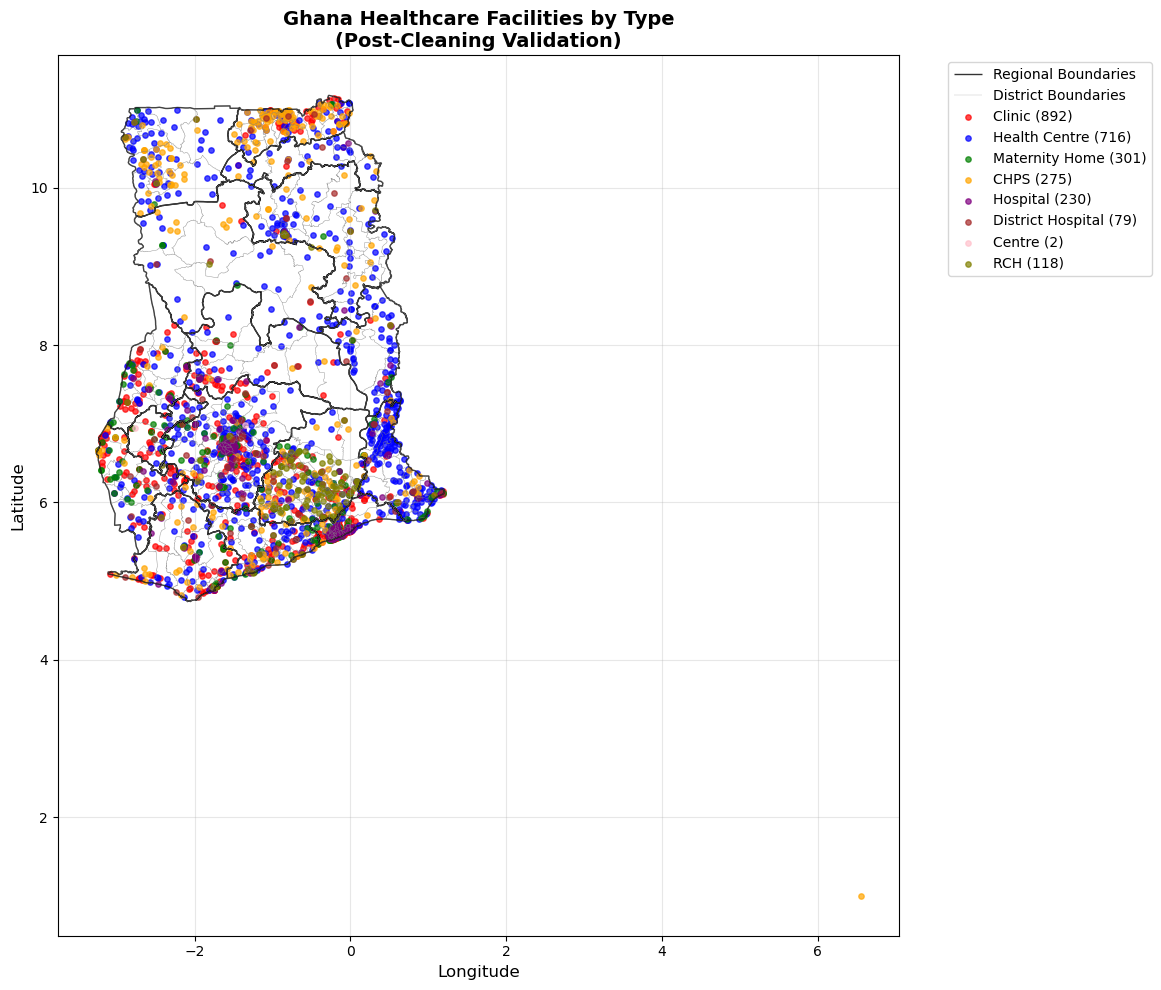

=== VALIDATION SUMMARY ===
Hospitals plotted: 2827
Regional boundaries: 16
District boundaries: 260


In [28]:
# Create validation plot to verify hospital and boundary alignment
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))

# Plot regional boundaries
regions.boundary.plot(ax=ax, color='black', linewidth=1, alpha=0.8, label='Regional Boundaries')

# Plot district boundaries (lighter)
districts.boundary.plot(ax=ax, color='gray', linewidth=0.3, alpha=0.5, label='District Boundaries')

# Plot hospitals by type with different colors
hospital_types = hospitals_clean['Type'].unique()
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'olive']

for i, htype in enumerate(hospital_types[:8]):  # Show top 8 types
    subset = hospitals_clean[hospitals_clean['Type'] == htype]
    ax.scatter(subset['longitude'], subset['latitude'], 
              c=colors[i], s=15, alpha=0.7, label=f'{htype} ({len(subset)})')

# Formatting
ax.set_title('Ghana Healthcare Facilities by Type\n(Post-Cleaning Validation)', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== VALIDATION SUMMARY ===")
print(f"Hospitals plotted: {len(hospitals_clean)}")
print(f"Regional boundaries: {len(regions)}")
print(f"District boundaries: {len(districts)}")

I can see there's a hospital plotted around longitude 6.5, which is clearly outside Ghana's boundaries. Moving on to identify and remove it:

In [29]:
# Find hospitals outside Ghana's approximate bounds
ghana_lat_bounds = (4.5, 11.2)  # Ghana latitude range
ghana_lon_bounds = (-3.3, 1.3)  # Ghana longitude range

# Identify outliers
outliers = hospitals_clean[
    (hospitals_clean['latitude'] < ghana_lat_bounds[0]) |
    (hospitals_clean['latitude'] > ghana_lat_bounds[1]) |
    (hospitals_clean['longitude'] < ghana_lon_bounds[0]) |
    (hospitals_clean['longitude'] > ghana_lon_bounds[1])
]

print("=== OUTLIER HOSPITALS FOUND ===")
if len(outliers) > 0:
    print(f"Number of outliers: {len(outliers)}")
    display_cols = ['OBJECTID', 'FacilityNa', 'Type', 'Region', 'latitude', 'longitude']
    print(outliers[display_cols].to_string(index=False))
else:
    print("No outliers found")

=== OUTLIER HOSPITALS FOUND ===
Number of outliers: 1
 OBJECTID    FacilityNa Type  Region  latitude  longitude
     2843 Dominebo CHPS CHPS Western       1.0    6.55529


In [30]:
# Remove outliers from dataset
hospitals_clean_final = hospitals_clean[
    (hospitals_clean['latitude'] >= ghana_lat_bounds[0]) &
    (hospitals_clean['latitude'] <= ghana_lat_bounds[1]) &
    (hospitals_clean['longitude'] >= ghana_lon_bounds[0]) &
    (hospitals_clean['longitude'] <= ghana_lon_bounds[1])
].copy()

print("=== OUTLIER REMOVAL SUMMARY ===")
print(f"Original hospitals (after duplicate cleaning): {len(hospitals_clean)}")
print(f"After outlier removal: {len(hospitals_clean_final)}")
print(f"Outliers removed: {len(hospitals_clean) - len(hospitals_clean_final)}")

=== OUTLIER REMOVAL SUMMARY ===
Original hospitals (after duplicate cleaning): 2827
After outlier removal: 2826
Outliers removed: 1


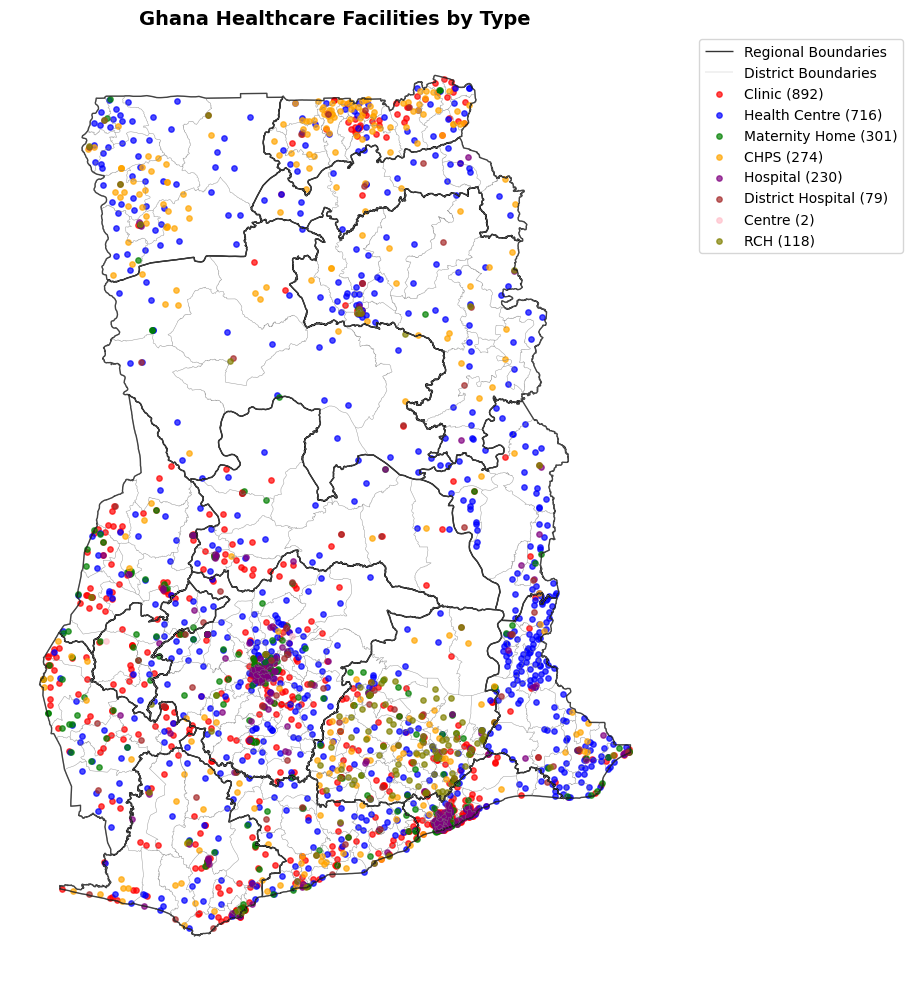

=== FINAL VALIDATION SUMMARY ===
Clean hospitals plotted: 2826


In [31]:
# Create clean validation plot without outliers
fig, ax = plt.subplots(figsize=(12, 10))

# Plot boundaries
regions.boundary.plot(ax=ax, color='black', linewidth=1, alpha=0.8, label='Regional Boundaries')
districts.boundary.plot(ax=ax, color='gray', linewidth=0.3, alpha=0.5, label='District Boundaries')

# Plot hospitals by type
hospital_types = hospitals_clean_final['Type'].unique()
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'olive']

for i, htype in enumerate(hospital_types[:8]):
    subset = hospitals_clean_final[hospitals_clean_final['Type'] == htype]
    ax.scatter(subset['longitude'], subset['latitude'], 
              c=colors[i], s=15, alpha=0.7, label=f'{htype} ({len(subset)})')

ax.set_title('Ghana Healthcare Facilities by Type', fontsize=14, fontweight='bold')
#ax.set_xlabel('Longitude', fontsize=12)
#ax.set_ylabel('Latitude', fontsize=12)

# Remove axis tick labels and grid
ax.set_xticks([])  # Remove longitude numbers
ax.set_yticks([])  # Remove latitude numbers
ax.grid(False)     # Remove grid lines
ax.spines['top'].set_visible(False)      # Remove top border
ax.spines['right'].set_visible(False)    # Remove right border  
ax.spines['bottom'].set_visible(False)   # Remove bottom border
ax.spines['left'].set_visible(False)     # Remove left border


ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== FINAL VALIDATION SUMMARY ===")
print(f"Clean hospitals plotted: {len(hospitals_clean_final)}")

In [32]:
# Update main hospital dataset
hospitals_clean = hospitals_clean_final.copy()

print(f"\n✅ Final hospital dataset: {len(hospitals_clean)} facilities")
print("Dataset ready for raster processing!")


✅ Final hospital dataset: 2826 facilities
Dataset ready for raster processing!


## SECTION 3B: Data Cleaning & Preprocessing (pop and malaria raster data)

### __3.1b  Handle Missing Values__

There a lot of pixels in both raster data sets with values less than 0. So I will use NaN to replace.  it preserves spatial structure while excluding invalid values from analysis.

In [33]:
# Replace invalid values with NaN to preserve raster structure
print("=== CLEANING RASTER DATA WITH NaN ===")

# Check original no-data values
pop_nodata_count = np.sum(pop_data == -99999)
malaria_nodata_count = np.sum(malaria_data == -9999)
pop_negative_count = np.sum(pop_data < 0)
malaria_negative_count = np.sum(malaria_data < 0)

print(f"Population no-data (-99999): {pop_nodata_count:,}")
print(f"Population negative values: {pop_negative_count:,}")
print(f"Malaria no-data (-9999): {malaria_nodata_count:,}")
print(f"Malaria negative values: {malaria_negative_count:,}")

=== CLEANING RASTER DATA WITH NaN ===
Population no-data (-99999): 13,735,538
Population negative values: 13,735,538
Malaria no-data (-9999): 5,555
Malaria negative values: 5,555


In [34]:
# Clean population data - replace invalid values with NaN
pop_data_clean = pop_data.copy().astype(float)       # Convert to float for NaN support
pop_data_clean[pop_data_clean < 0] = np.nan          # Replace negative values with NaN
pop_data_clean[pop_data_clean == -99999] = np.nan    # Replace no-data with NaN

print(f"Population: Replaced {np.sum(pop_data < 0):,} invalid values with NaN")
print(f"Valid population pixels: {np.sum(~np.isnan(pop_data_clean)):,}")

Population: Replaced 13,735,538 invalid values with NaN
Valid population pixels: 27,471,439


In [35]:
# Clean malaria data - replace invalid values with NaN  
malaria_data_clean = malaria_data.copy().astype(float)  # Convert to float for NaN support
malaria_data_clean[malaria_data_clean < 0] = np.nan      # Replace negative values with NaN
malaria_data_clean[malaria_data_clean == -9999] = np.nan # Replace no-data with NaN

print(f"Malaria: Replaced {np.sum(malaria_data < 0):,} invalid values with NaN")
print(f"Valid malaria pixels: {np.sum(~np.isnan(malaria_data_clean)):,}")

Malaria: Replaced 5,555 invalid values with NaN
Valid malaria pixels: 11,030


In [36]:
# Summary of cleaned data
print("\n=== CLEANED RASTER SUMMARY ===")
print(f"Population raster shape: {pop_data_clean.shape}")
print(f"Malaria raster shape: {malaria_data_clean.shape}")
print(f"Population valid pixels: {np.sum(~np.isnan(pop_data_clean)):,}")
print(f"Malaria valid pixels: {np.sum(~np.isnan(malaria_data_clean)):,}")
print(f"Population data range: {np.nanmin(pop_data_clean):.1f} to {np.nanmax(pop_data_clean):.1f}")
print(f"Malaria data range: {np.nanmin(malaria_data_clean):.1f} to {np.nanmax(malaria_data_clean):.1f}")


=== CLEANED RASTER SUMMARY ===
Population raster shape: (7721, 5337)
Malaria raster shape: (155, 107)
Population valid pixels: 27,471,439
Malaria valid pixels: 11,030
Population data range: 0.0 to 240.7
Malaria data range: 0.0 to 0.4


### __3.2b Standardise Coordinate Systems__ 

Raw Data (EPSG:4326)

    ↓ 
    
Scale to 1km (EPSG:4326) ← DO THIS FIRST

    ↓ 
Transform to UTM (EPSG:32630) ← THEN THIS

    ↓   
P-median Optimization

In [37]:
# Verify all raster CRS alignment
print("\n=== COORDINATE SYSTEM VERIFICATION ===")
print(f"Population raster CRS: {pop_raster.crs}")
print(f"Malaria raster CRS: {malaria_raster.crs}")
print(f"Hospital/boundary CRS: {regions.crs}")

# Check if all coordinate systems match
all_crs_match = (pop_raster.crs == malaria_raster.crs == regions.crs)
print(f"All CRS systems match: {all_crs_match}")

if all_crs_match:
    print("✅ No coordinate transformation needed")
else:
    print("⚠️ Coordinate transformation required")


=== COORDINATE SYSTEM VERIFICATION ===
Population raster CRS: EPSG:4326
Malaria raster CRS: EPSG:4326
Hospital/boundary CRS: EPSG:4326
All CRS systems match: True
✅ No coordinate transformation needed


### __3.3b Scaling Raster resolution to 1km__ 

📝 Raster Resolution Scaling Strategy

Our raster datasets have different resolutions that need harmonization before analysis. The population data has ~90m resolution (high detail) while malaria incidence has ~5km resolution (coarse detail). We need both at 1km resolution for optimal P-median analysis.

For population data, we'll aggregate from 90m to 1km by summing population counts within larger cells, preserving total population while reducing detail. For malaria data, we'll interpolate from 5km to 1km using bilinear interpolation to estimate incidence rates for smaller areas.

This scaling approach ensures both datasets are compatible at 1km resolution before transforming to UTM coordinates. Scaling first in the original CRS, then transforming to UTM avoids double resampling and maintains better data quality for accurate P-median optimization.


In [38]:
# Check current data status before scaling

print("=== CURRENT DATA STATUS ===")
print(f"Population shape: {pop_data_clean.shape}")
print(f"Malaria shape: {malaria_data_clean.shape}")
print(f"Population valid pixels: {np.sum(~np.isnan(pop_data_clean)):,}")
print(f"Malaria valid pixels: {np.sum(~np.isnan(malaria_data_clean)):,}")

=== CURRENT DATA STATUS ===
Population shape: (7721, 5337)
Malaria shape: (155, 107)
Population valid pixels: 27,471,439
Malaria valid pixels: 11,030


In [39]:
# checking exact resolutions

# Calculate exact resolutions in meters
pop_res_deg = 0.00083333  # Population pixel size in degrees
malaria_res_deg = 0.04166  # Malaria pixel size in degrees

# Convert to meters (at Ghana's latitude ~7°N)
meters_per_degree = 111000 * np.cos(np.radians(7))
pop_res_m = pop_res_deg * meters_per_degree  # ~92 meters
malaria_res_m = malaria_res_deg * meters_per_degree  # ~4590 meters

print(f"Population resolution: {pop_res_m:.0f} meters")
print(f"Malaria resolution: {malaria_res_m:.0f} meters")

Population resolution: 92 meters
Malaria resolution: 4590 meters


In [40]:
# Calculating scaling factors for 1km res target

# Calculate how to scale to 1km (1000m) resolution
target_res = 1000  # 1km in meters

# Population: 92m → 1000m means combine ~11x11 pixels into 1
pop_factor = int(round(target_res / pop_res_m))

# Malaria: 4590m → 1000m means create ~4.6x more pixels  
malaria_factor = malaria_res_m / target_res

print(f"Population aggregation factor: {pop_factor} (combine {pop_factor}x{pop_factor} pixels)")
print(f"Malaria upsampling factor: {malaria_factor:.1f} (create {malaria_factor:.1f}x more pixels)")

Population aggregation factor: 11 (combine 11x11 pixels)
Malaria upsampling factor: 4.6 (create 4.6x more pixels)


#### __3.3.1b Population Scaling (92m → 1km via aggregation)__ 

In [41]:
# 3.3.1b Population Scaling (92m → 1km via aggregation)

# Import required library for population aggregation
from skimage.measure import block_reduce
import numpy as np

print("\n=== SCALING POPULATION DATA ===")
print("Aggregating population from 92m to 1km resolution...")

# Calculate aggregation factor (11x11 pixels → 1 pixel)
aggregation_factor = 11  # From earlier calculation: 1000m/92m ≈ 11

# Function to aggregate population data preserving total population
def aggregate_population_raster(data, factor):
    """
    Aggregate population raster by summing values within blocks.
    Properly handles NaN values to avoid contamination.
    
    Parameters:
    - data: 2D numpy array with population values (may contain NaN)
    - factor: aggregation factor (e.g., 11 for 11x11 → 1)
    
    Returns:
    - aggregated_data: downsampled array with summed population
    """
    # Handle edge cases - crop to make dimensions divisible by factor
    h, w = data.shape
    new_h = (h // factor) * factor  # Make height divisible by factor
    new_w = (w // factor) * factor  # Make width divisible by factor
    
    # Crop the data to fit exact blocks
    cropped_data = data[:new_h, :new_w]
    print(f"   Original shape: {data.shape}")
    print(f"   Cropped shape: {cropped_data.shape}")
    
    # Method 1: Use nansum for proper NaN handling
    # Reshape data into blocks and sum, ignoring NaN values
    reshaped = cropped_data.reshape(
        new_h // factor, factor,  # New height, block height
        new_w // factor, factor   # New width, block width
    )
    
    # Sum along the block dimensions (axis 1 and 3), ignoring NaN
    # This gives us the population sum for each 1km block
    aggregated = np.nansum(reshaped, axis=(1, 3))
    
    # Create validity mask - block is valid if it has at least one non-NaN value
    # Count valid (non-NaN) pixels in each block
    valid_count = np.sum(~np.isnan(reshaped), axis=(1, 3))
    
    # Set blocks with no valid pixels to NaN
    # If valid_count == 0, the entire block was NaN
    aggregated = np.where(valid_count > 0, aggregated, np.nan)
    
    print(f"   Blocks with valid data: {np.sum(~np.isnan(aggregated)):,}")
    print(f"   Blocks set to NaN: {np.sum(np.isnan(aggregated)):,}")
    
    return aggregated

# Apply aggregation to cleaned population data
print(f"   Aggregation factor: {aggregation_factor}x{aggregation_factor}")
print("   Processing aggregation...")

pop_data_1km = aggregate_population_raster(pop_data_clean, aggregation_factor)

# Validation and summary
print(f"\n=== AGGREGATION RESULTS ===")
print(f"Original resolution: ~92m")
print(f"New resolution: ~1km")
print(f"Original shape: {pop_data_clean.shape}")
print(f"New shape: {pop_data_1km.shape}")

# Calculate actual resolution change
original_pixels = pop_data_clean.shape[0] * pop_data_clean.shape[1]
new_pixels = pop_data_1km.shape[0] * pop_data_1km.shape[1]
reduction_factor = original_pixels / new_pixels

print(f"Pixel count reduction: {original_pixels:,} → {new_pixels:,}")
print(f"Reduction factor: {reduction_factor:.1f}x")

# Validate population conservation
original_total_pop = np.nansum(pop_data_clean)
new_total_pop = np.nansum(pop_data_1km)
population_difference = abs(original_total_pop - new_total_pop)
conservation_rate = (new_total_pop / original_total_pop) * 100

print(f"\n=== POPULATION CONSERVATION CHECK ===")
print(f"Original total population: {original_total_pop:,.0f}")
print(f"Aggregated total population: {new_total_pop:,.0f}")
print(f"Difference: {population_difference:,.0f}")
print(f"Conservation rate: {conservation_rate:.2f}%")

if conservation_rate > 99.5:
    print("✅ Population well conserved during aggregation")
else:
    print("⚠️  Significant population loss during aggregation")

# Data quality metrics
valid_pixels_original = np.sum(~np.isnan(pop_data_clean))
valid_pixels_new = np.sum(~np.isnan(pop_data_1km))

print(f"\n=== DATA QUALITY METRICS ===")
print(f"Valid pixels original: {valid_pixels_original:,}")
print(f"Valid pixels aggregated: {valid_pixels_new:,}")
print(f"Original data range: {np.nanmin(pop_data_clean):.1f} to {np.nanmax(pop_data_clean):.1f}")
print(f"Aggregated data range: {np.nanmin(pop_data_1km):.1f} to {np.nanmax(pop_data_1km):.1f}")

# Create new raster metadata for the aggregated data
print(f"\n=== RASTER METADATA UPDATE ===")
# Calculate new pixel size (approximately 1km)
original_pixel_size = 0.00083333  # degrees
new_pixel_size = original_pixel_size * aggregation_factor
new_pixel_size_meters = new_pixel_size * 111000  # Convert to meters at equator

print(f"New pixel size: {new_pixel_size:.6f} degrees")
print(f"New pixel size: ~{new_pixel_size_meters:.0f} meters")

print("✅ Population data successfully aggregated to 1km resolution")
print("Ready for UTM transformation and P-median optimization")


=== SCALING POPULATION DATA ===
Aggregating population from 92m to 1km resolution...
   Aggregation factor: 11x11
   Processing aggregation...
   Original shape: (7721, 5337)
   Cropped shape: (7711, 5335)
   Blocks with valid data: 230,809
   Blocks set to NaN: 109,176

=== AGGREGATION RESULTS ===
Original resolution: ~92m
New resolution: ~1km
Original shape: (7721, 5337)
New shape: (701, 485)
Pixel count reduction: 41,206,977 → 339,985
Reduction factor: 121.2x

=== POPULATION CONSERVATION CHECK ===
Original total population: 33,039,564
Aggregated total population: 33,037,023
Difference: 2,541
Conservation rate: 99.99%
✅ Population well conserved during aggregation

=== DATA QUALITY METRICS ===
Valid pixels original: 27,471,439
Valid pixels aggregated: 230,809
Original data range: 0.0 to 240.7
Aggregated data range: 0.1 to 27482.0

=== RASTER METADATA UPDATE ===
New pixel size: 0.009167 degrees
New pixel size: ~1017 meters
✅ Population data successfully aggregated to 1km resolution
R

#### __3.3.2b Malaria Scaling (4.6km → 1km via upsampling)__ 

In [42]:
# 3.3.2b Malaria Scaling (5km → 1km via interpolation)

from scipy.ndimage import zoom
import numpy as np

print("\n=== SCALING MALARIA DATA ===")
print("Interpolating malaria from 5km to 1km resolution...")

# Calculate upsampling factor (5km → 1km = 5x increase)
upsampling_factor = 4.6  # From earlier: 4590m / 1000m = 4.6

print(f"   Upsampling factor: {upsampling_factor:.1f}x")
print(f"   Original shape: {malaria_data_clean.shape}")

# Use scipy zoom for bilinear interpolation
# This smoothly interpolates malaria incidence rates between pixels
malaria_data_1km = zoom(
    malaria_data_clean, 
    zoom=upsampling_factor,  # Scale factor for each dimension
    order=1,  # Bilinear interpolation (smooth for rates)
    prefilter=False  # Preserve original values
)

print(f"   New shape: {malaria_data_1km.shape}")

# Validation metrics
print(f"\n=== INTERPOLATION RESULTS ===")
print(f"Original resolution: ~5km")
print(f"New resolution: ~1km") 
print(f"Shape change: {malaria_data_clean.shape} → {malaria_data_1km.shape}")

# Check data integrity
original_valid = np.sum(~np.isnan(malaria_data_clean))
new_valid = np.sum(~np.isnan(malaria_data_1km))
pixel_increase = (malaria_data_1km.size / malaria_data_clean.size)

print(f"Pixel count increase: {malaria_data_clean.size:,} → {malaria_data_1km.size:,}")
print(f"Increase factor: {pixel_increase:.1f}x")

# Data range validation  
print(f"\n=== DATA QUALITY CHECK ===")
print(f"Original range: {np.nanmin(malaria_data_clean):.3f} to {np.nanmax(malaria_data_clean):.3f}")
print(f"Interpolated range: {np.nanmin(malaria_data_1km):.3f} to {np.nanmax(malaria_data_1km):.3f}")
print(f"Valid pixels: {original_valid:,} → {new_valid:,}")

# Check if interpolation preserved data characteristics
mean_preservation = np.nanmean(malaria_data_1km) / np.nanmean(malaria_data_clean)
print(f"Mean value preservation: {mean_preservation:.1%}")

if 0.95 <= mean_preservation <= 1.05:
    print("✅ Malaria incidence values well preserved")
else:
    print("⚠️  Significant change in malaria incidence values")

print("✅ Malaria data successfully interpolated to 1km resolution")
print("Ready for UTM transformation alongside population data")


=== SCALING MALARIA DATA ===
Interpolating malaria from 5km to 1km resolution...
   Upsampling factor: 4.6x
   Original shape: (155, 107)
   New shape: (713, 492)

=== INTERPOLATION RESULTS ===
Original resolution: ~5km
New resolution: ~1km
Shape change: (155, 107) → (713, 492)
Pixel count increase: 16,585 → 350,796
Increase factor: 21.2x

=== DATA QUALITY CHECK ===
Original range: 0.000 to 0.441
Interpolated range: 0.014 to 0.438
Valid pixels: 11,030 → 227,655
Mean value preservation: 100.0%
✅ Malaria incidence values well preserved
✅ Malaria data successfully interpolated to 1km resolution
Ready for UTM transformation alongside population data


#### Why UTM for CRS?

##### Problem with EPSG:4326
- Uses degrees (not real distance)
- 1° longitude ≠ consistent distance across Ghana
- P-median optimization gives wrong results

##### Solution: UTM Zone 30N
- Units in meters (real distance)
- Optimized for Ghana (<0.1% distortion)
- Accurate facility placement calculations

##### Impact
- **Geographic CRS**: Wrong facility locations
- **UTM CRS**: Correct, actionable healthcare planning

Essential for meaningful P-median optimization.

### __3.4b UTM Transformation__ 

#### __3.4.1b Transform Raster Data to UTM__ 

In [43]:
# 3.4b UTM Transformation for 1km Scaled Data

from rasterio.warp import reproject, Resampling, calculate_default_transform
import rasterio.transform
import numpy as np

print("=== TRANSFORMING 1KM DATA TO UTM ===")

# Define target CRS and resolution
ghana_utm_crs = 'EPSG:32630'  # UTM Zone 30N for Ghana
target_resolution = 1000  # 1km in meters

print(f"Target CRS: {ghana_utm_crs}")
print(f"Target resolution: {target_resolution}m")

# Define Ghana bounds in geographic coordinates (EPSG:4326)
ghana_bounds = (-3.25, 4.75, 1.25, 11.25)  # (west, south, east, north)

# Calculate UTM transformation parameters
dst_transform, dst_width, dst_height = calculate_default_transform(
    src_crs='EPSG:4326',
    dst_crs=ghana_utm_crs,
    width=pop_data_1km.shape[1],  # Use population data as reference
    height=pop_data_1km.shape[0],
    left=ghana_bounds[0], bottom=ghana_bounds[1],
    right=ghana_bounds[2], top=ghana_bounds[3],
    resolution=target_resolution
)

print(f"UTM grid size: {dst_width} x {dst_height}")

# Create source transform for geographic data
src_transform = rasterio.transform.from_bounds(
    *ghana_bounds, 
    pop_data_1km.shape[1], 
    pop_data_1km.shape[0]
)

# Transform population data to UTM
print("\n--- Transforming Population Data ---")
pop_data_utm = np.empty((dst_height, dst_width), dtype=np.float32)

reproject(
    source=pop_data_1km,
    destination=pop_data_utm,
    src_transform=src_transform,
    src_crs='EPSG:4326',
    dst_transform=dst_transform,
    dst_crs=ghana_utm_crs,
    resampling=Resampling.bilinear,  # Smooth for population density
    src_nodata=np.nan,
    dst_nodata=np.nan
)

print(f"Population UTM shape: {pop_data_utm.shape}")
print(f"Valid pixels: {np.sum(~np.isnan(pop_data_utm)):,}")

# Transform malaria data to UTM (same grid)
print("\n--- Transforming Malaria Data ---")
malaria_data_utm = np.empty((dst_height, dst_width), dtype=np.float32)

# Create source transform for malaria (may have different dimensions)
malaria_src_transform = rasterio.transform.from_bounds(
    *ghana_bounds,
    malaria_data_1km.shape[1],
    malaria_data_1km.shape[0]
)

reproject(
    source=malaria_data_1km,
    destination=malaria_data_utm,
    src_transform=malaria_src_transform,
    src_crs='EPSG:4326',
    dst_transform=dst_transform,
    dst_crs=ghana_utm_crs,
    resampling=Resampling.bilinear,  # Smooth for incidence rates
    src_nodata=np.nan,
    dst_nodata=np.nan
)

print(f"Malaria UTM shape: {malaria_data_utm.shape}")
print(f"Valid pixels: {np.sum(~np.isnan(malaria_data_utm)):,}")

# Validation summary
print(f"\n=== UTM TRANSFORMATION SUMMARY ===")
print(f"Both datasets now in: {ghana_utm_crs}")
print(f"Grid resolution: {target_resolution}m x {target_resolution}m")
print(f"Grid dimensions: {dst_width} x {dst_height}")

# Data range checks
print(f"\nPopulation range: {np.nanmin(pop_data_utm):.1f} to {np.nanmax(pop_data_utm):.1f}")
print(f"Malaria range: {np.nanmin(malaria_data_utm):.3f} to {np.nanmax(malaria_data_utm):.3f}")

print("✅ Both datasets transformed to UTM and aligned")
print("Ready for hospital data transformation")

=== TRANSFORMING 1KM DATA TO UTM ===
Target CRS: EPSG:32630
Target resolution: 1000m
UTM grid size: 500 x 722

--- Transforming Population Data ---
Population UTM shape: (722, 500)
Valid pixels: 242,084

--- Transforming Malaria Data ---
Malaria UTM shape: (722, 500)
Valid pixels: 231,602

=== UTM TRANSFORMATION SUMMARY ===
Both datasets now in: EPSG:32630
Grid resolution: 1000m x 1000m
Grid dimensions: 500 x 722

Population range: 0.2 to 27293.1
Malaria range: 0.028 to 0.438
✅ Both datasets transformed to UTM and aligned
Ready for hospital data transformation


#### __3.4.2b Transform Vector Data to UTM__ 

In [44]:
# 3.4c Vector Data UTM Transformation

import geopandas as gpd
from shapely.geometry import Point

print("\n=== TRANSFORMING VECTOR DATA TO UTM ===")

# Transform regional boundaries
regions_utm = regions.to_crs(ghana_utm_crs)
print(f"Regions: {len(regions_utm)} boundaries → {ghana_utm_crs}")

# Transform district boundaries  
districts_utm = districts.to_crs(ghana_utm_crs)
print(f"Districts: {len(districts_utm)} boundaries → {ghana_utm_crs}")

# Transform hospital data
# First create GeoDataFrame from cleaned hospital coordinates
hospitals_gdf = gpd.GeoDataFrame(
    hospitals_clean,
    geometry=[Point(lon, lat) for lon, lat in 
              zip(hospitals_clean['longitude'], hospitals_clean['latitude'])],
    crs='EPSG:4326'
)

# Transform to UTM
hospitals_utm = hospitals_gdf.to_crs(ghana_utm_crs)
print(f"Hospitals: {len(hospitals_utm)} facilities → {ghana_utm_crs}")

# Extract UTM coordinates for easy access
hospitals_utm['x_utm'] = hospitals_utm.geometry.x
hospitals_utm['y_utm'] = hospitals_utm.geometry.y

# Coordinate range validation
print(f"\n=== UTM COORDINATE RANGES ===")
print(f"Hospitals X: {hospitals_utm['x_utm'].min():.0f} to {hospitals_utm['x_utm'].max():.0f}")
print(f"Hospitals Y: {hospitals_utm['y_utm'].min():.0f} to {hospitals_utm['y_utm'].max():.0f}")

# Verify all data aligned in same CRS
print(f"\n=== CRS VERIFICATION ===")
print(f"Regions CRS: {regions_utm.crs}")
print(f"Hospitals CRS: {hospitals_utm.crs}")
print(f"Raster CRS: {ghana_utm_crs}")

print("✅ All vector data transformed to UTM")
print("✅ Hospitals, boundaries, and rasters now aligned")


=== TRANSFORMING VECTOR DATA TO UTM ===
Regions: 16 boundaries → EPSG:32630
Districts: 260 boundaries → EPSG:32630
Hospitals: 2826 facilities → EPSG:32630

=== UTM COORDINATE RANGES ===
Hospitals X: 473928 to 964175
Hospitals Y: 530195 to 1233633

=== CRS VERIFICATION ===
Regions CRS: EPSG:32630
Hospitals CRS: EPSG:32630
Raster CRS: EPSG:32630
✅ All vector data transformed to UTM
✅ Hospitals, boundaries, and rasters now aligned


## __4.1  DATA VALIDATION MAPS__

=== CREATING FINAL VALIDATION MAPS ===


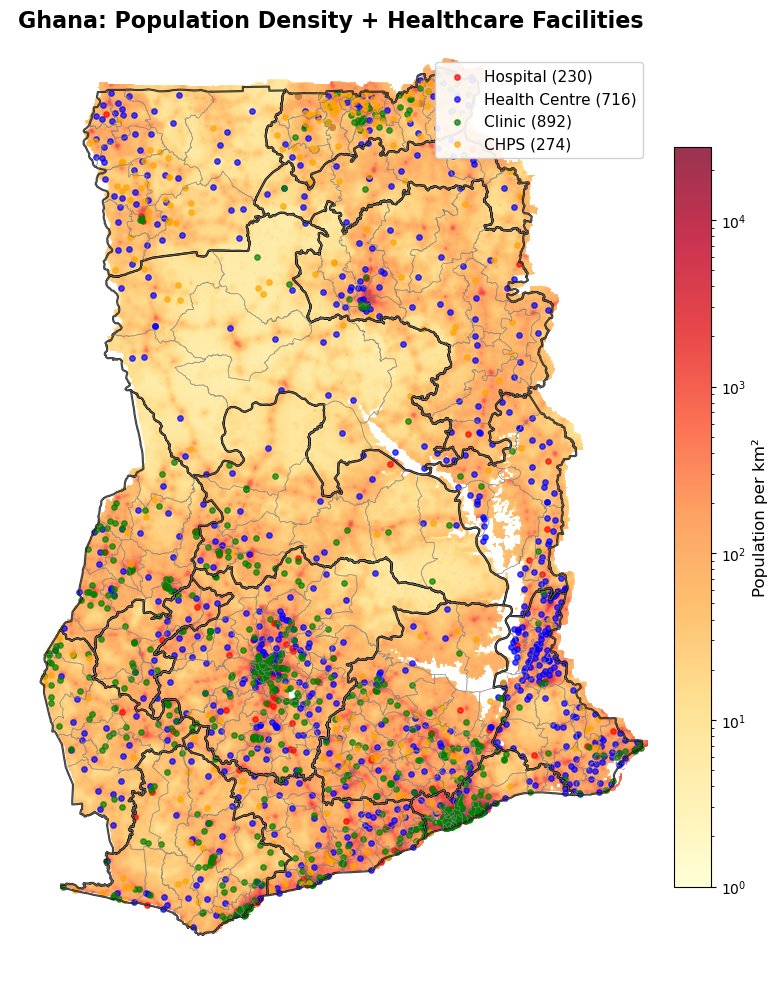

✅ Map 1: Population + Healthcare Facilities displayed


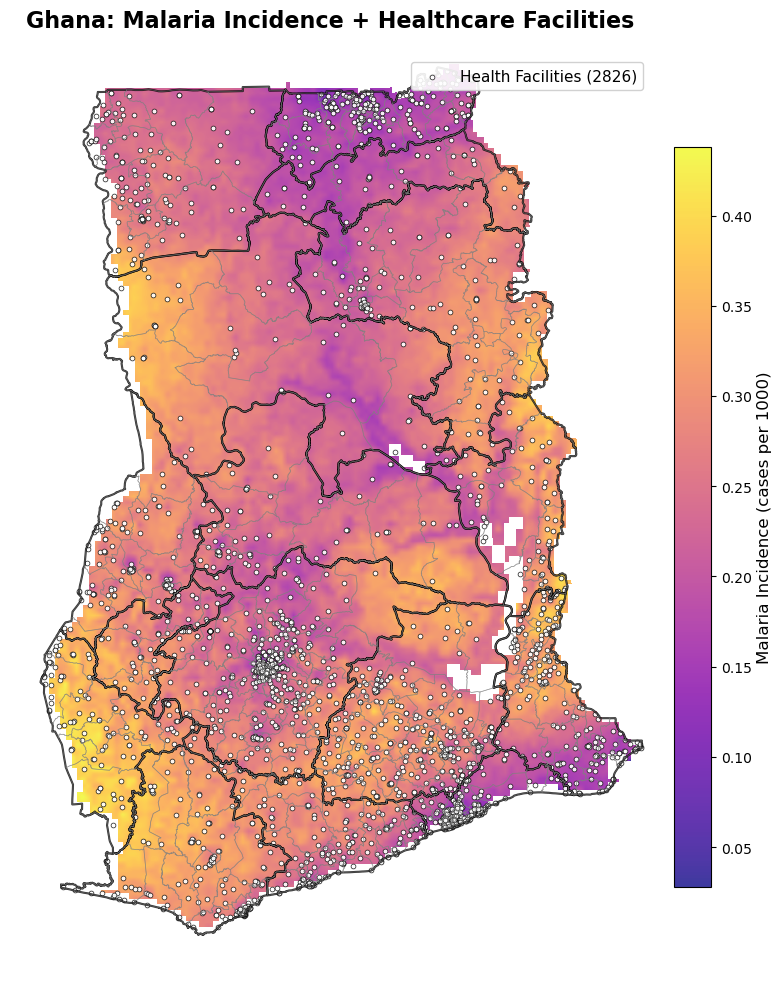

✅ Map 2: Malaria Incidence + Healthcare Facilities displayed

=== FINAL DATA SUMMARY ===
📊 POPULATION DATA (UTM)
   Resolution: 1000m x 1000m
   Grid size: 500 x 722
   Valid pixels: 242,084
   Population range: 0 - 27293 per km²
   Total population: 34,744,744

🦟 MALARIA DATA (UTM)
   Resolution: 1000m x 1000m
   Grid size: 500 x 722
   Valid pixels: 231,602
   Incidence range: 0.028 - 0.438 per 1000

🏥 HEALTHCARE FACILITIES (UTM)
   Total facilities: 2826
   Coordinate range X: 473928 - 964175m
   Coordinate range Y: 530195 - 1233633m
   Facility breakdown:
     Clinic: 892
     Health Centre: 716
     Maternity Home: 301
     CHPS: 274
     Hospital: 230
     RCH: 118

🗺️  ADMINISTRATIVE BOUNDARIES (UTM)
   Regions: 16
   Districts: 260
   CRS: EPSG:32630

✅ DATA PREPARATION COMPLETE
   All datasets aligned in UTM Zone 30N
   1km resolution for optimal P-median analysis
   Ready for healthcare accessibility optimization
   Total data points: 242,084 grid cells + 2826 facilities


In [45]:
# FINAL DATA VALIDATION MAPS

import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import plotting_extent
from matplotlib.colors import LogNorm

print("=== CREATING FINAL VALIDATION MAPS ===")

# Create separate figures for each map
# Will create 2 individual maps instead of side-by-side

# ===============================
# MAP 1: POPULATION + HOSPITALS + BOUNDARIES
# ===============================

# Create first figure
fig1, ax1 = plt.subplots(1, 1, figsize=(12, 10))

# Create extent for population raster in UTM
pop_extent = [
    dst_transform.c,  # left (min x)
    dst_transform.c + dst_transform.a * dst_width,  # right (max x)  
    dst_transform.f + dst_transform.e * dst_height,  # bottom (min y)
    dst_transform.f  # top (max y)
]

# Plot population data with log scale (better visualization)
pop_masked = np.ma.masked_where(np.isnan(pop_data_utm), pop_data_utm)
im1 = ax1.imshow(
    pop_masked, 
    extent=pop_extent,
    cmap='YlOrRd',  # Yellow to Red colormap
    norm=LogNorm(vmin=1, vmax=np.nanmax(pop_data_utm)),  # Log scale
    alpha=0.8,
    aspect='equal'
)

# Add regional boundaries
regions_utm.boundary.plot(ax=ax1, color='black', linewidth=1.5, alpha=0.8)

# Add district boundaries (lighter)
districts_utm.boundary.plot(ax=ax1, color='gray', linewidth=0.5, alpha=0.6)

# Add hospitals by type
hospital_types = ['Hospital', 'Health Centre', 'Clinic', 'CHPS']
colors = ['red', 'blue', 'green', 'orange']

for htype, color in zip(hospital_types, colors):
    subset = hospitals_utm[hospitals_utm['Type'] == htype]
    if len(subset) > 0:
        ax1.scatter(subset['x_utm'], subset['y_utm'], 
                   c=color, s=15, alpha=0.7, label=f'{htype} ({len(subset)})')

# Formatting Map 1
ax1.set_title('Ghana: Population Density + Healthcare Facilities', 
              fontsize=16, fontweight='bold', pad=20)
ax1.legend(loc='upper right', fontsize=11, framealpha=0.9)

# Remove axis tick labels and grid
ax1.set_xticks([])  # Remove longitude numbers
ax1.set_yticks([])  # Remove latitude numbers
ax1.grid(False)     # Remove grid lines
ax1.spines['top'].set_visible(False)      # Remove top border
ax1.spines['right'].set_visible(False)    # Remove right border  
ax1.spines['bottom'].set_visible(False)   # Remove bottom border
ax1.spines['left'].set_visible(False)     # Remove left border

# Add colorbar for population
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8, pad=0.02)
cbar1.set_label('Population per km²', fontsize=12)

plt.tight_layout()
plt.show()

print("✅ Map 1: Population + Healthcare Facilities displayed")

# ===============================
# MAP 2: MALARIA + HOSPITALS + BOUNDARIES  
# ===============================

# Create second figure
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 10))

# Plot malaria incidence data
malaria_masked = np.ma.masked_where(np.isnan(malaria_data_utm), malaria_data_utm)
im2 = ax2.imshow(
    malaria_masked,
    extent=pop_extent,  # Same extent as population
    cmap='plasma',  # Red colormap for disease incidence
    alpha=0.8,
    aspect='equal'
)

# Add regional boundaries
regions_utm.boundary.plot(ax=ax2, color='black', linewidth=1.5, alpha=0.8)

# Add district boundaries (lighter)
districts_utm.boundary.plot(ax=ax2, color='gray', linewidth=0.5, alpha=0.6)

# Add hospitals (all types, simpler visualization)
ax2.scatter(hospitals_utm['x_utm'], hospitals_utm['y_utm'], 
           c='white', s=12, alpha=0.9, edgecolors='black', linewidth=0.5,
           label=f'Health Facilities ({len(hospitals_utm)})')

# Formatting Map 2
ax2.set_title('Ghana: Malaria Incidence + Healthcare Facilities', 
              fontsize=16, fontweight='bold', pad=20)
ax2.legend(loc='upper right', fontsize=11, framealpha=0.9)

# Remove axis tick labels and grid
ax2.set_xticks([])  # Remove longitude numbers
ax2.set_yticks([])  # Remove latitude numbers
ax2.grid(False)     # Remove grid lines
ax2.spines['top'].set_visible(False)      # Remove top border
ax2.spines['right'].set_visible(False)    # Remove right border  
ax2.spines['bottom'].set_visible(False)   # Remove bottom border
ax2.spines['left'].set_visible(False)     # Remove left border

# Add colorbar for malaria
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8, pad=0.02)
cbar2.set_label('Malaria Incidence (cases per 1000)', fontsize=12)

plt.tight_layout()
plt.show()

print("✅ Map 2: Malaria Incidence + Healthcare Facilities displayed")



# ===============================
# SUMMARY STATISTICS
# ===============================
print("\n=== FINAL DATA SUMMARY ===")
print(f"📊 POPULATION DATA (UTM)")
print(f"   Resolution: {target_resolution}m x {target_resolution}m")
print(f"   Grid size: {dst_width} x {dst_height}")
print(f"   Valid pixels: {np.sum(~np.isnan(pop_data_utm)):,}")
print(f"   Population range: {np.nanmin(pop_data_utm):.0f} - {np.nanmax(pop_data_utm):.0f} per km²")
print(f"   Total population: {np.nansum(pop_data_utm):,.0f}")

print(f"\n🦟 MALARIA DATA (UTM)")
print(f"   Resolution: {target_resolution}m x {target_resolution}m") 
print(f"   Grid size: {dst_width} x {dst_height}")
print(f"   Valid pixels: {np.sum(~np.isnan(malaria_data_utm)):,}")
print(f"   Incidence range: {np.nanmin(malaria_data_utm):.3f} - {np.nanmax(malaria_data_utm):.3f} per 1000")

print(f"\n🏥 HEALTHCARE FACILITIES (UTM)")
print(f"   Total facilities: {len(hospitals_utm)}")
print(f"   Coordinate range X: {hospitals_utm['x_utm'].min():.0f} - {hospitals_utm['x_utm'].max():.0f}m")
print(f"   Coordinate range Y: {hospitals_utm['y_utm'].min():.0f} - {hospitals_utm['y_utm'].max():.0f}m")

# Facility type breakdown
print(f"   Facility breakdown:")
for ftype in hospitals_utm['Type'].value_counts().head(6).index:
    count = len(hospitals_utm[hospitals_utm['Type'] == ftype])
    print(f"     {ftype}: {count}")

print(f"\n🗺️  ADMINISTRATIVE BOUNDARIES (UTM)")
print(f"   Regions: {len(regions_utm)}")
print(f"   Districts: {len(districts_utm)}")
print(f"   CRS: {ghana_utm_crs}")

print(f"\n✅ DATA PREPARATION COMPLETE")
print(f"   All datasets aligned in UTM Zone 30N")
print(f"   1km resolution for optimal P-median analysis")
print(f"   Ready for healthcare accessibility optimization")
print(f"   Total data points: {np.sum(~np.isnan(pop_data_utm)):,} grid cells + {len(hospitals_utm)} facilities")

In [46]:
# SAVE PROCESSED DATA FOR NEXT NOTEBOOK

import pickle
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.transform import from_bounds

print("=== SAVING PROCESSED DATA ===")

# Create output directory
import os
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}/")

# ===============================
# 1. SAVE RASTER DATA (UTM)
# ===============================

# Save population raster as GeoTIFF
pop_profile = {
    'driver': 'GTiff',
    'height': pop_data_utm.shape[0],
    'width': pop_data_utm.shape[1],
    'count': 1,
    'dtype': 'float32',
    'crs': ghana_utm_crs,
    'transform': dst_transform,
    'nodata': np.nan
}

with rasterio.open(f"{output_dir}/population_1km_utm.tif", 'w', **pop_profile) as dst:
    dst.write(pop_data_utm.astype('float32'), 1)

print("✅ Population raster saved: population_1km_utm.tif")

# Save malaria raster as GeoTIFF  
malaria_profile = pop_profile.copy()  # Same grid as population

with rasterio.open(f"{output_dir}/malaria_1km_utm.tif", 'w', **malaria_profile) as dst:
    dst.write(malaria_data_utm.astype('float32'), 1)

print("✅ Malaria raster saved: malaria_1km_utm.tif")

# ===============================
# 2. SAVE VECTOR DATA (UTM)
# ===============================

# Save hospital data
hospitals_utm.to_file(f"{output_dir}/hospitals_utm.geojson", driver="GeoJSON")
print(f"✅ Hospitals saved: hospitals_utm.geojson ({len(hospitals_utm)} facilities)")

# Save regional boundaries
regions_utm.to_file(f"{output_dir}/regions_utm.geojson", driver="GeoJSON")
print(f"✅ Regional boundaries saved: regions_utm.geojson ({len(regions_utm)} regions)")

# Save district boundaries
districts_utm.to_file(f"{output_dir}/districts_utm.geojson", driver="GeoJSON")
print(f"✅ District boundaries saved: districts_utm.geojson ({len(districts_utm)} districts)")

# ===============================
# 3. SAVE GRID PARAMETERS
# ===============================

# Save key parameters for next notebook
grid_params = {
    'crs': ghana_utm_crs,
    'transform': dst_transform,
    'width': dst_width,
    'height': dst_height,
    'resolution': target_resolution,
    'bounds': {
        'left': dst_transform.c,
        'right': dst_transform.c + dst_transform.a * dst_width,
        'bottom': dst_transform.f + dst_transform.e * dst_height,
        'top': dst_transform.f
    }
}

with open(f"{output_dir}/grid_parameters.pkl", 'wb') as f:
    pickle.dump(grid_params, f)

print("✅ Grid parameters saved: grid_parameters.pkl")

# ===============================
# 4. SAVE SUMMARY METADATA
# ===============================

# Create summary for documentation
summary = {
    'data_preparation_date': '2025-01-30',
    'coordinate_system': ghana_utm_crs,
    'resolution': f"{target_resolution}m",
    'grid_dimensions': f"{dst_width} x {dst_height}",
    'datasets': {
        'population': {
            'file': 'population_1km_utm.tif',
            'source': 'WorldPop 2020',
            'valid_pixels': int(np.sum(~np.isnan(pop_data_utm))),
            'total_population': int(np.nansum(pop_data_utm)),
            'range': f"{np.nanmin(pop_data_utm):.0f} - {np.nanmax(pop_data_utm):.0f} per km²"
        },
        'malaria': {
            'file': 'malaria_1km_utm.tif', 
            'source': 'Malaria Atlas Project 2020',
            'valid_pixels': int(np.sum(~np.isnan(malaria_data_utm))),
            'range': f"{np.nanmin(malaria_data_utm):.3f} - {np.nanmax(malaria_data_utm):.3f} per 1000"
        },
        'hospitals': {
            'file': 'hospitals_utm.geojson',
            'source': 'Ghana Health Service Registry',
            'count': len(hospitals_utm),
            'types': hospitals_utm['Type'].value_counts().head(5).to_dict()
        },
        'boundaries': {
            'regions_file': 'regions_utm.geojson',
            'districts_file': 'districts_utm.geojson',
            'source': 'GADM v4.1',
            'regions_count': len(regions_utm),
            'districts_count': len(districts_utm)
        }
    }
}

with open(f"{output_dir}/data_summary.pkl", 'wb') as f:
    pickle.dump(summary, f)

print("✅ Data summary saved: data_summary.pkl")

# ===============================
# 5. CREATE LOADING SCRIPT
# ===============================

loading_script = '''# LOAD PROCESSED DATA FOR P-MEDIAN ANALYSIS

import pickle
import numpy as np
import rasterio
import geopandas as gpd

print("=== LOADING PROCESSED DATA ===")

# Load raster data
with rasterio.open("processed_data/population_1km_utm.tif") as src:
    pop_data_utm = src.read(1)
    pop_transform = src.transform
    pop_crs = src.crs

with rasterio.open("processed_data/malaria_1km_utm.tif") as src:
    malaria_data_utm = src.read(1)

# Load vector data  
hospitals_utm = gpd.read_file("processed_data/hospitals_utm.geojson")
regions_utm = gpd.read_file("processed_data/regions_utm.geojson")
districts_utm = gpd.read_file("processed_data/districts_utm.geojson")

# Load grid parameters
with open("processed_data/grid_parameters.pkl", "rb") as f:
    grid_params = pickle.load(f)

# Load summary
with open("processed_data/data_summary.pkl", "rb") as f:
    data_summary = pickle.load(f)

print("✅ All data loaded successfully!")
print(f"Population grid: {pop_data_utm.shape}")
print(f"Malaria grid: {malaria_data_utm.shape}") 
print(f"Hospitals: {len(hospitals_utm)} facilities")
print(f"CRS: {pop_crs}")
'''

with open(f"{output_dir}/load_data.py", 'w') as f:
    f.write(loading_script)

print("✅ Loading script created: load_data.py")

# ===============================
# FINAL SUMMARY
# ===============================

print(f"\n🎉 DATA SUCCESSFULLY SAVED!")
print(f"📁 Output folder: {output_dir}/")
print(f"📊 Files created:")
print(f"   • population_1km_utm.tif")
print(f"   • malaria_1km_utm.tif") 
print(f"   • hospitals_utm.geojson")
print(f"   • regions_utm.geojson")
print(f"   • districts_utm.geojson")
print(f"   • grid_parameters.pkl")
print(f"   • data_summary.pkl")
print(f"   • load_data.py")

print(f"\n🚀 TO USE IN NEXT NOTEBOOK:")
print(f"   Run: exec(open('processed_data/load_data.py').read())")
print(f"   All variables will be loaded and ready for P-median optimization!")

# Show file sizes
total_size = 0
for filename in os.listdir(output_dir):
    filepath = os.path.join(output_dir, filename)
    size = os.path.getsize(filepath) / (1024*1024)  # MB
    total_size += size
    print(f"   {filename}: {size:.1f} MB")

print(f"\n💾 Total size: {total_size:.1f} MB")

=== SAVING PROCESSED DATA ===
Output directory: processed_data/
✅ Population raster saved: population_1km_utm.tif
✅ Malaria raster saved: malaria_1km_utm.tif
✅ Hospitals saved: hospitals_utm.geojson (2826 facilities)
✅ Regional boundaries saved: regions_utm.geojson (16 regions)
✅ District boundaries saved: districts_utm.geojson (260 districts)
✅ Grid parameters saved: grid_parameters.pkl
✅ Data summary saved: data_summary.pkl
✅ Loading script created: load_data.py

🎉 DATA SUCCESSFULLY SAVED!
📁 Output folder: processed_data/
📊 Files created:
   • population_1km_utm.tif
   • malaria_1km_utm.tif
   • hospitals_utm.geojson
   • regions_utm.geojson
   • districts_utm.geojson
   • grid_parameters.pkl
   • data_summary.pkl
   • load_data.py

🚀 TO USE IN NEXT NOTEBOOK:
   Run: exec(open('processed_data/load_data.py').read())
   All variables will be loaded and ready for P-median optimization!
   data_summary.pkl: 0.0 MB
   districts_utm.geojson: 33.0 MB
   grid_parameters.pkl: 0.0 MB
   hospit

In [47]:
# Just run this one line:
#exec(open('processed_data/load_data.py').read())

# All variables will be loaded:
# pop_data_utm, malaria_data_utm, hospitals_utm, etc.

In [48]:
hospitals_utm

,OBJECTID,Region,District,FacilityNa,Type,Town,Ownership,latitude,longitude,geometry,index_right,NAME_1,x_utm,y_utm
0,1,Ashanti,Offinso North,A.M.E Zion Clinic,Clinic,Afrancho,CHAG,7.40801,-1.96317,POINT (614422.662 818986.851),1.0,Ashanti,614422.661515,8.189869e+05
1,2,Ashanti,Bekwai Municipal,Abenkyiman Clinic,Clinic,Anwiankwanta,Private,6.46312,-1.58592,POINT (656373.863 714616.547),1.0,Ashanti,656373.862730,7.146165e+05
2,3,Ashanti,Adansi North,Aboabo Health Centre,Health Centre,Aboabo No 2,Government,6.22393,-1.34982,POINT (682573.395 688243.477),1.0,Ashanti,682573.395292,6.882435e+05
3,4,Ashanti,Afigya-Kwabre,Aboabogya Health Centre,Health Centre,Aboabogya,Government,6.84177,-1.61098,POINT (653484.49 756478.812),1.0,Ashanti,653484.490296,7.564788e+05
4,5,Ashanti,Kwabre,Aboaso Health Centre,Health Centre,Aboaso,Government,6.84177,-1.61098,POINT (653484.49 756478.812),1.0,Ashanti,653484.490296,7.564788e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2837,2838,Western,Wassa-Amenfi West,Gravel Yard Clinic.,Clinic,Gravel Yard,Government,5.41941,-2.46114,POINT (559696.252 599052.057),14.0,Western,559696.252195,5.990521e+05
2838,2839,Western,Wassa-Amenfi West,St.Theresa Clinic,Clinic,Nope,CHAG,5.44135,-2.50321,POINT (555033.522 601473.416),14.0,Western,555033.522320,6.014734e+05
2839,2840,Western,Wassa-Amenfi West,Samartex Hospital,Hospital,Samreboi,Quasi-Government,5.61599,-2.56413,POINT (548270.625 620773.526),14.0,Western,548270.624598,6.207735e+05
2840,2841,Western,Shama Ahanta East,Infirmary Clinic,CHPS,Ping,Government,10.37467,-2.30288,POINT (576313.848 1146921.405),12.0,Upper West,576313.848379,1.146921e+06
